## **1. Configuración y ETL**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para los gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Carga de datos
df = pd.read_csv('Superstore.csv', encoding='latin1')

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [ ]:
#Limpieza de datos
# Limpieza de Espacios
df['Customer Name'] = df['Customer Name'].str.strip()
df['Product Name'] = df['Product Name'].str.strip()

# El 'Row ID' no aporta valor estadístico.
df.drop(columns=['Row ID'], inplace=True)

# E. Verificación de Duplicados:
df.drop_duplicates(inplace=True)

In [ ]:
# Transformación de tipos y nuevas variables
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df['Profit_Margin'] = (df['Profit'] / df['Sales']) * 100
df['Order_Month'] = df['Order Date'].dt.to_period('M').astype(str)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)


# **2. Análisis por Punto de Control**
A. Correlación Descuento vs. Rentabilidad

*Objetivo: Determinar el impacto financiero de la política de precios.*

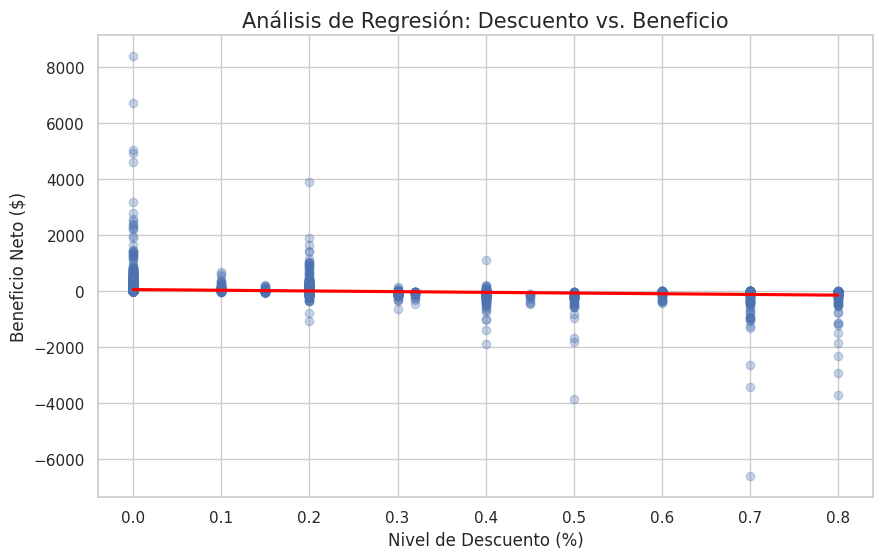

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Discount', y='Profit', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Análisis de Regresión: Descuento vs. Beneficio', fontsize=15)
plt.xlabel('Nivel de Descuento (%)')
plt.ylabel('Beneficio Neto ($)')
plt.show()

**Insight**: La línea de regresión roja muestra una clara tendencia negativa. A medida que el descuento supera el 20%, el beneficio cae drásticamente.

# **B. Rendimiento Geográfico (Heatmap de Ganancias)**
*Objetivo: Visualizar qué regiones están "quemando" capital.*

/tmp/ipython-input-330685845.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_geo.head(10), x='Profit', y='State', palette='Reds_r')


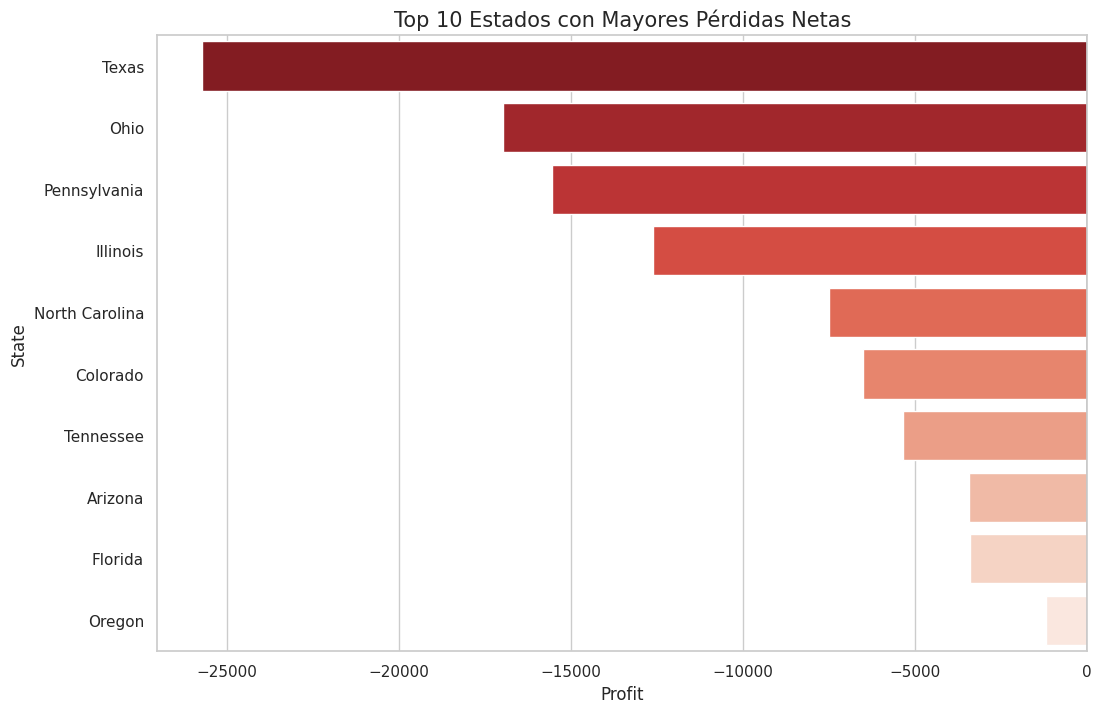

In [ ]:
state_geo = df.groupby('State')['Profit'].sum().reset_index().sort_values(by='Profit')

plt.figure(figsize=(12, 8))
sns.barplot(data=state_geo.head(10), x='Profit', y='State', palette='Reds_r')
plt.title('Top 10 Estados con Mayores Pérdidas Netas', fontsize=15)
plt.axvline(0, color='black', lw=1)
plt.show()

**Insight:** Texas y Ohio son los puntos críticos. No es un problema de ventas (volumen), sino de margen operativo en esos estados específicos.

# **C. Composición de Ventas por Categoría**
*Objetivo: Identificar el mix de productos y su salud financiera.*

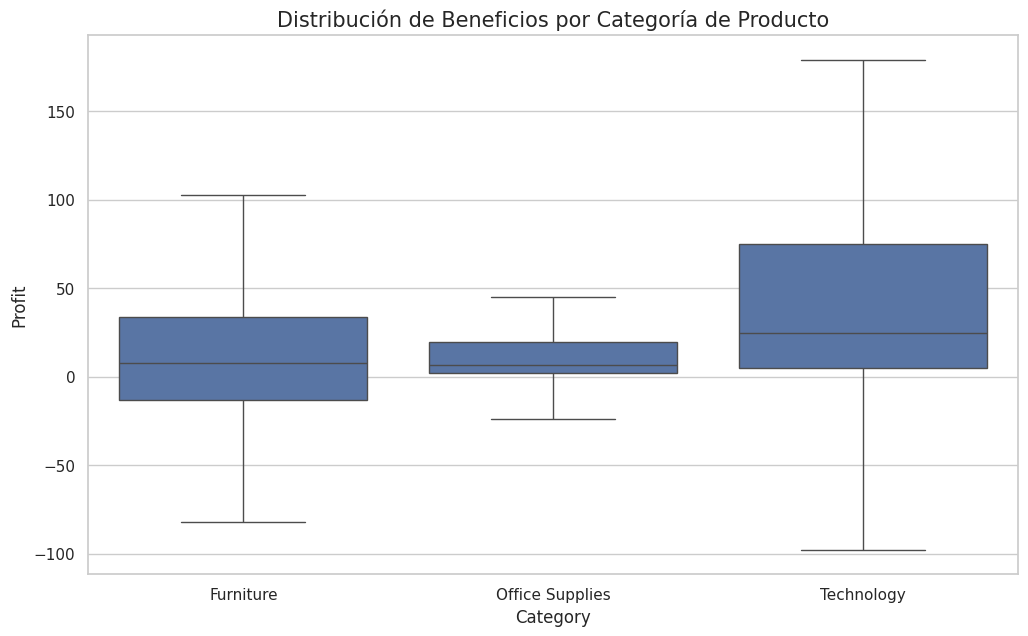

In [ ]:
cat_analysis = df.groupby(['Category', 'Sub-Category'])['Profit'].sum().reset_index()

plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='Category', y='Profit', showfliers=False) # showfliers=False para evitar ruido de outliers
plt.title('Distribución de Beneficios por Categoría de Producto', fontsize=15)
plt.show()

**Insight:** La categoría Technology tiene la mediana de beneficios más alta. Furniture muestra una dispersión peligrosa, con muchos productos operando cerca del punto de equilibrio o en pérdida.

# **D. Análisis Temporal y Estacionalidad**
*Objetivo: Entender cuándo el flujo de caja es más vulnerable.*

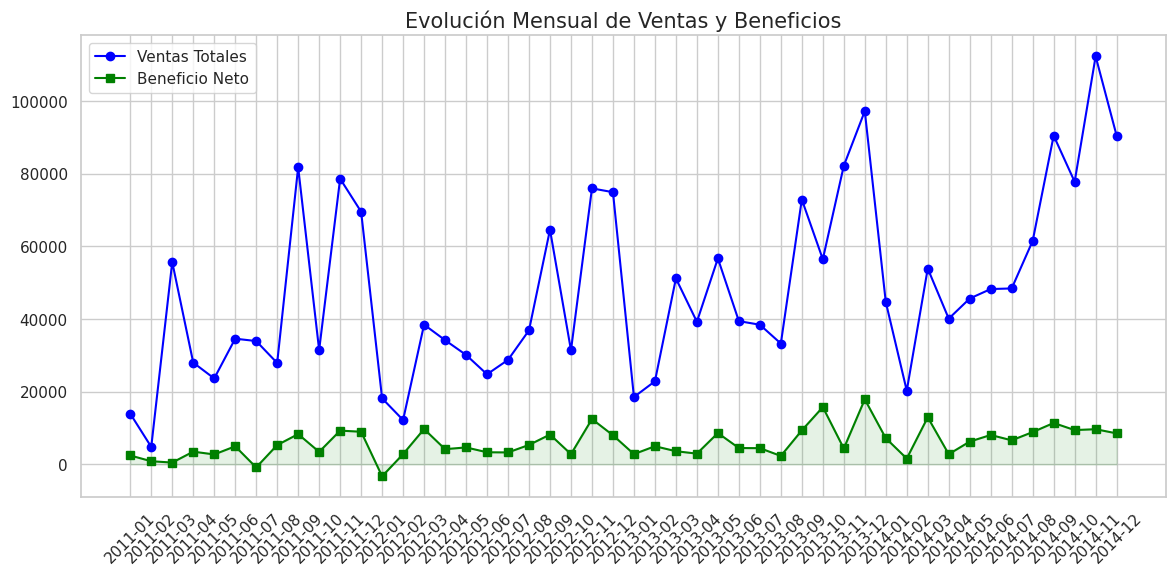

In [ ]:
monthly_sales = df.groupby('Order_Month')[['Sales', 'Profit']].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['Order_Month'], monthly_sales['Sales'], label='Ventas Totales', marker='o', color='blue')
plt.plot(monthly_sales['Order_Month'], monthly_sales['Profit'], label='Beneficio Neto', marker='s', color='green')
plt.fill_between(monthly_sales['Order_Month'], monthly_sales['Profit'], color='green', alpha=0.1)
plt.xticks(rotation=45)
plt.title('Evolución Mensual de Ventas y Beneficios', fontsize=15)
plt.legend()
plt.show()

**Insight**: Existe una estacionalidad marcada hacia el final del año (Q4). Sin embargo, el beneficio no crece proporcionalmente a las ventas en diciembre, lo que sugiere un exceso de gastos de envío o promociones de fin de año.

# **E. Eficiencia de Envío (Logística)**
*Objetivo: Medir la rapidez vs. costo.*

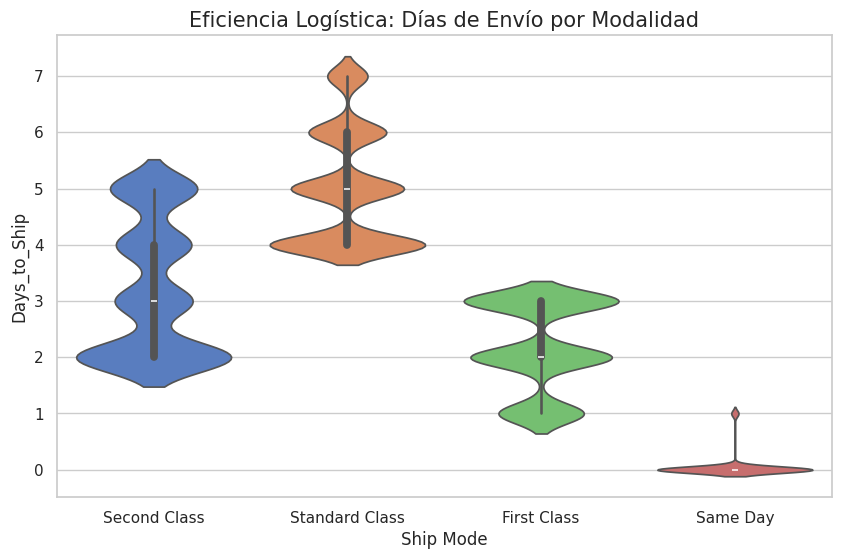

In [41]:
df['Days_to_Ship'] = (df['Ship Date'] - df['Order Date']).dt.days

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Ship Mode', hue='Ship Mode', y='Days_to_Ship', palette='muted', legend=False)
plt.title('Eficiencia Logística: Días de Envío por Modalidad', fontsize=15)
plt.show()

**Insight**: La modalidad "Standard Class" tiene una variabilidad de 4 a 7 días. Reducir esta ventana a una constante de 4 días podría mejorar la satisfacción del cliente y la rotación de inventario.

# **3. Conclusión Final**

Este proyecto demuestra que el éxito de un negocio no reside solo en vender más, sino en vender mejor. Descrubri que:


*   Los descuentos son el enemigo silencioso: Superar el 20% destruye el margen.
*   Focalización: Debemos reducir la inversión en el segmento de Furniture en Texas y reasignarla a Technology en regiones rentables.
* Logística: Existe espacio para estandarizar los tiempos de envío y reducir costos operativos.

